# Facial Recognition System
## Formative 2 - Data Preprocessing Assignment - Part 2

This notebook implements a complete facial recognition system for user authentication.

## Step 1: Import Libraries

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import hog
import joblib
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print("All libraries imported successfully")

All libraries imported successfully


## Step 2: Load Images

Load all team member images from the images folder.

In [17]:
# Set up directories
IMAGE_DIR = 'images'
MODEL_DIR = 'models'
FEATURE_DIR = 'features'

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)

# Load all images from the images folder
images_data = []

if os.path.exists(IMAGE_DIR):
    for img_file in os.listdir(IMAGE_DIR):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(IMAGE_DIR, img_file)
            img = cv2.imread(img_path)
            
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Extract member info from filename
                # Assuming filenames contain member identifiers
                if 'IMG_9631' in img_file or 'IMG_9632' in img_file or 'IMG_9633' in img_file:
                    member = 'Member1'
                elif 'e9f9bfbe' in img_file or '5a5539bd' in img_file or 'eb9bdc7c' in img_file:
                    member = 'Member2'
                elif '4272da32' in img_file or 'bdc12d05' in img_file or 'c4f0e73e' in img_file:
                    member = 'Member3'
                elif 'f19c6775' in img_file or '3459b16c' in img_file or 'e1f95694' in img_file:
                    member = 'Member4'
                else:
                    member = 'Unknown'
                
                images_data.append({
                    'path': img_path,
                    'member': member,
                    'image': img_rgb,
                    'filename': img_file
                })

df_images = pd.DataFrame(images_data)
print(f"Loaded {len(df_images)} images")
print(f"Members found: {df_images['member'].unique()}")
print(f"\nImages per member:")
print(df_images['member'].value_counts())

Loaded 12 images
Members found: ['Member1' 'Member2' 'Member3' 'Member4']

Images per member:
member
Member1    3
Member2    3
Member3    3
Member4    3
Name: count, dtype: int64


## Step 3: Display Sample Images

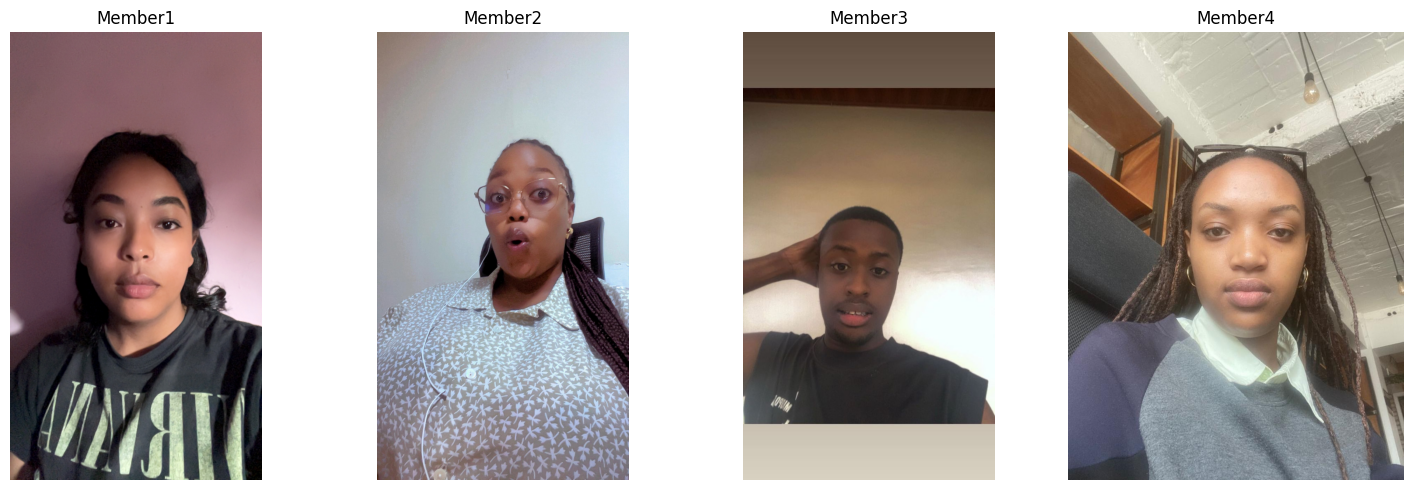

In [18]:
# Display first image from each member
members = df_images['member'].unique()
n_members = len(members)

fig, axes = plt.subplots(1, n_members, figsize=(15, 5))
if n_members == 1:
    axes = [axes]

for i, member in enumerate(members):
    subset = df_images[df_images['member'] == member]
    if len(subset) > 0:
        img = subset.iloc[0]['image']
        axes[i].imshow(img)
        axes[i].set_title(member)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## Step 4: Image Augmentation

Apply multiple augmentations to increase dataset size and improve model robustness.

In [19]:
def augment_image(img):
    """
    Apply various augmentations to an image.
    Returns list of augmented images.
    """
    augmented = []
    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    
    # Original
    augmented.append(('original', img))
    
    # Rotation +15 degrees
    M = cv2.getRotationMatrix2D(center, 15, 1.0)
    rotated_pos = cv2.warpAffine(img, M, (width, height))
    augmented.append(('rotated_15', rotated_pos))
    
    # Rotation -15 degrees
    M = cv2.getRotationMatrix2D(center, -15, 1.0)
    rotated_neg = cv2.warpAffine(img, M, (width, height))
    augmented.append(('rotated_-15', rotated_neg))
    
    # Horizontal flip
    flipped = cv2.flip(img, 1)
    augmented.append(('flipped', flipped))
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    augmented.append(('grayscale', gray_rgb))
    
    # Brightness increase
    bright = cv2.convertScaleAbs(img, alpha=1.2, beta=30)
    augmented.append(('brightness_up', bright))
    
    # Brightness decrease
    dark = cv2.convertScaleAbs(img, alpha=0.8, beta=-30)
    augmented.append(('brightness_down', dark))
    
    # Gaussian blur
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    augmented.append(('blurred', blurred))
    
    return augmented

# Apply augmentation to all images
augmented_data = []

for idx, row in df_images.iterrows():
    augmentations = augment_image(row['image'])
    
    for aug_type, aug_img in augmentations:
        augmented_data.append({
            'member': row['member'],
            'augmentation': aug_type,
            'image': aug_img,
            'original_filename': row['filename']
        })

df_augmented = pd.DataFrame(augmented_data)
print(f"Total images after augmentation: {len(df_augmented)}")
print(f"Original images: {len(df_images)}")
print(f"Augmentations per image: {len(df_augmented) // len(df_images)}")

Total images after augmentation: 96
Original images: 12
Augmentations per image: 8


## Step 5: Display Augmentation Examples

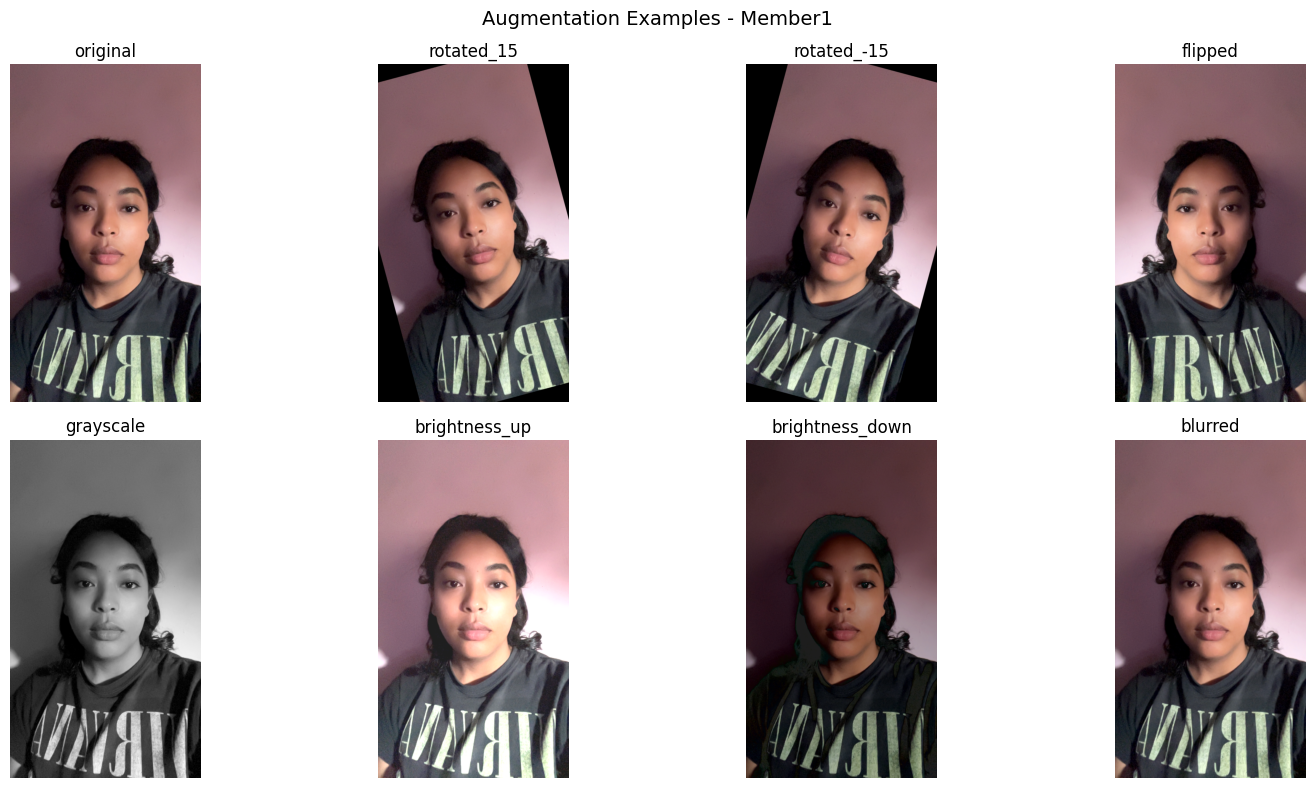

In [20]:
# Show augmentation examples for first member
if len(df_augmented) > 0:
    first_member = df_augmented['member'].iloc[0]
    first_file = df_augmented['original_filename'].iloc[0]
    
    subset = df_augmented[(df_augmented['member'] == first_member) & 
                          (df_augmented['original_filename'] == first_file)]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, (idx, row) in enumerate(subset.iterrows()):
        if i < 8:
            axes[i].imshow(row['image'])
            axes[i].set_title(row['augmentation'])
            axes[i].axis('off')
    
    plt.suptitle(f'Augmentation Examples - {first_member}', fontsize=14)
    plt.tight_layout()
    plt.show()

## Step 6: Feature Extraction

Extract 217 features from each image including color histograms, HOG descriptors, and statistical features.

In [21]:
def extract_features(img, resize_shape=(128, 128)):
    """
    Extract features from an image.
    Returns a feature vector with 217 features.
    """
    features = []
    
    # Resize image
    img_resized = cv2.resize(img, resize_shape)
    
    # Color histograms for each channel
    for channel in range(3):
        hist = cv2.calcHist([img_resized], [channel], None, [32], [0, 256])
        hist = hist.flatten() / hist.sum()
        features.extend(hist)
    
    # Statistical features per channel
    for channel in range(3):
        channel_data = img_resized[:, :, channel]
        features.append(np.mean(channel_data))
        features.append(np.std(channel_data))
        features.append(np.median(channel_data))
        features.append(np.min(channel_data))
        features.append(np.max(channel_data))
    
    # Grayscale conversion
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    
    # Edge detection
    edges = cv2.Canny(gray, 100, 200)
    features.append(np.sum(edges > 0) / edges.size)
    
    # HOG features
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
    features.extend(hog_features[:100])
    
    # Texture variance
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    features.append(np.var(laplacian))
    
    # Additional grayscale statistics
    features.append(np.mean(gray))
    features.append(np.std(gray))
    features.append(np.median(gray))
    features.append(np.var(gray))
    
    return np.array(features)

# Extract features from all augmented images
print("Extracting features...")
feature_list = []

for idx, row in df_augmented.iterrows():
    features = extract_features(row['image'])
    
    feature_dict = {
        'member': row['member'],
        'augmentation': row['augmentation']
    }
    
    for i, feat_val in enumerate(features):
        feature_dict[f'feature_{i}'] = feat_val
    
    feature_list.append(feature_dict)

df_features = pd.DataFrame(feature_list)
print(f"Feature extraction complete")
print(f"Dataset shape: {df_features.shape}")
print(f"Features per image: {len([col for col in df_features.columns if 'feature_' in col])}")

Extracting features...
Feature extraction complete
Dataset shape: (96, 219)
Features per image: 217
Feature extraction complete
Dataset shape: (96, 219)
Features per image: 217


## Step 7: Save Features to CSV

In [22]:
# Save features
feature_csv_path = os.path.join(FEATURE_DIR, 'image_features.csv')
df_features.to_csv(feature_csv_path, index=False)
print(f"Features saved to: {feature_csv_path}")

# Display sample
print("\nFirst few rows:")
df_features.head()

Features saved to: features\image_features.csv

First few rows:


,member,augmentation,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216
0,Member1,original,0.038025,0.037231,0.028748,0.031494,0.033508,0.036682,0.052063,0.055359,...,0.139563,0.228238,0.204083,0.121351,0.228238,2863.693780,93.759644,56.919366,97.0,3239.814177
1,Member1,rotated_15,0.151062,0.032104,0.023926,0.027466,0.029236,0.029114,0.048340,0.053101,...,0.022257,0.020601,0.011845,0.005460,0.025376,3095.916610,83.169495,61.966514,73.0,3839.848896
2,Member1,rotated_-15,0.155518,0.033752,0.023926,0.023132,0.026550,0.030823,0.046631,0.050232,...,0.000000,0.000000,0.000000,0.000000,0.195376,3686.445233,82.887024,62.415594,74.0,3895.706414
3,Member1,flipped,0.038025,0.037231,0.028748,0.031494,0.033508,0.036682,0.052063,0.055359,...,0.237244,0.209508,0.068304,0.180559,0.237244,2863.693780,93.759644,56.919366,97.0,3239.814177
4,Member1,grayscale,0.054077,0.035339,0.023254,0.028198,0.038574,0.040344,0.045593,0.062500,...,0.138391,0.225638,0.197701,0.120332,0.225638,2862.760519,93.760681,56.916924,97.0,3239.536293


## Step 8: Prepare Data for Training

In [23]:
# Separate features and labels
feature_columns = [col for col in df_features.columns if 'feature_' in col]
X = df_features[feature_columns].values
y = df_features['member'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Number of features: {X.shape[1]}")
print(f"Number of members: {len(label_encoder.classes_)}")
print(f"Members: {label_encoder.classes_}")

Training set: 76 samples
Test set: 20 samples
Number of features: 217
Number of members: 4
Members: ['Member1' 'Member2' 'Member3' 'Member4']


## Step 9: Train Random Forest Model

In [24]:
# Train Random Forest
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train_rf = rf_model.predict(X_train_scaled)
y_pred_test_rf = rf_model.predict(X_test_scaled)

# Calculate metrics
train_acc_rf = accuracy_score(y_train, y_pred_train_rf)
test_acc_rf = accuracy_score(y_test, y_pred_test_rf)
train_f1_rf = f1_score(y_train, y_pred_train_rf, average='weighted')
test_f1_rf = f1_score(y_test, y_pred_test_rf, average='weighted')

print(f"\nRandom Forest Results:")
print(f"Training Accuracy: {train_acc_rf:.4f}")
print(f"Test Accuracy: {test_acc_rf:.4f}")
print(f"Training F1-Score: {train_f1_rf:.4f}")
print(f"Test F1-Score: {test_f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_rf, target_names=label_encoder.classes_))

Training Random Forest Classifier...

Random Forest Results:
Training Accuracy: 1.0000
Test Accuracy: 1.0000
Training F1-Score: 1.0000
Test F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Member1       1.00      1.00      1.00         5
     Member2       1.00      1.00      1.00         5
     Member3       1.00      1.00      1.00         5
     Member4       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


Random Forest Results:
Training Accuracy: 1.0000
Test Accuracy: 1.0000
Training F1-Score: 1.0000
Test F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Member1       1.00      1.00      1.00         5
     Member2       1.00      1.00      1.00         5
     Member3       1.00      1.00      1.00         5
     Member4       1.00

## Step 10: Train Logistic Regression Model

In [25]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train_lr = lr_model.predict(X_train_scaled)
y_pred_test_lr = lr_model.predict(X_test_scaled)

# Calculate metrics
train_acc_lr = accuracy_score(y_train, y_pred_train_lr)
test_acc_lr = accuracy_score(y_test, y_pred_test_lr)
train_f1_lr = f1_score(y_train, y_pred_train_lr, average='weighted')
test_f1_lr = f1_score(y_test, y_pred_test_lr, average='weighted')

print(f"\nLogistic Regression Results:")
print(f"Training Accuracy: {train_acc_lr:.4f}")
print(f"Test Accuracy: {test_acc_lr:.4f}")
print(f"Training F1-Score: {train_f1_lr:.4f}")
print(f"Test F1-Score: {test_f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_lr, target_names=label_encoder.classes_))

Training Logistic Regression...

Logistic Regression Results:
Training Accuracy: 1.0000
Test Accuracy: 0.9500
Training F1-Score: 1.0000
Test F1-Score: 0.9495

Classification Report:
              precision    recall  f1-score   support

     Member1       1.00      1.00      1.00         5
     Member2       1.00      1.00      1.00         5
     Member3       0.83      1.00      0.91         5
     Member4       1.00      0.80      0.89         5

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



## Step 11: Visualize Confusion Matrices

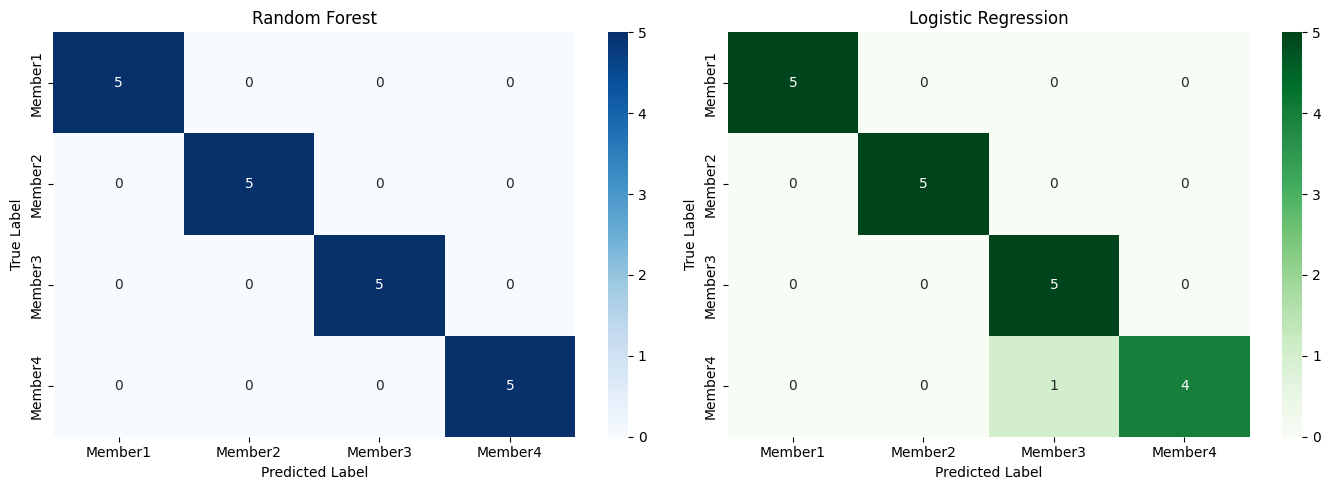

In [26]:
# Create confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0])
axes[0].set_title('Random Forest')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_test_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[1])
axes[1].set_title('Logistic Regression')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## Step 12: Compare Model Performance

Model Performance Comparison:
              Model  Train Accuracy  Test Accuracy  Train F1-Score  Test F1-Score
      Random Forest             1.0           1.00             1.0       1.000000
Logistic Regression             1.0           0.95             1.0       0.949495


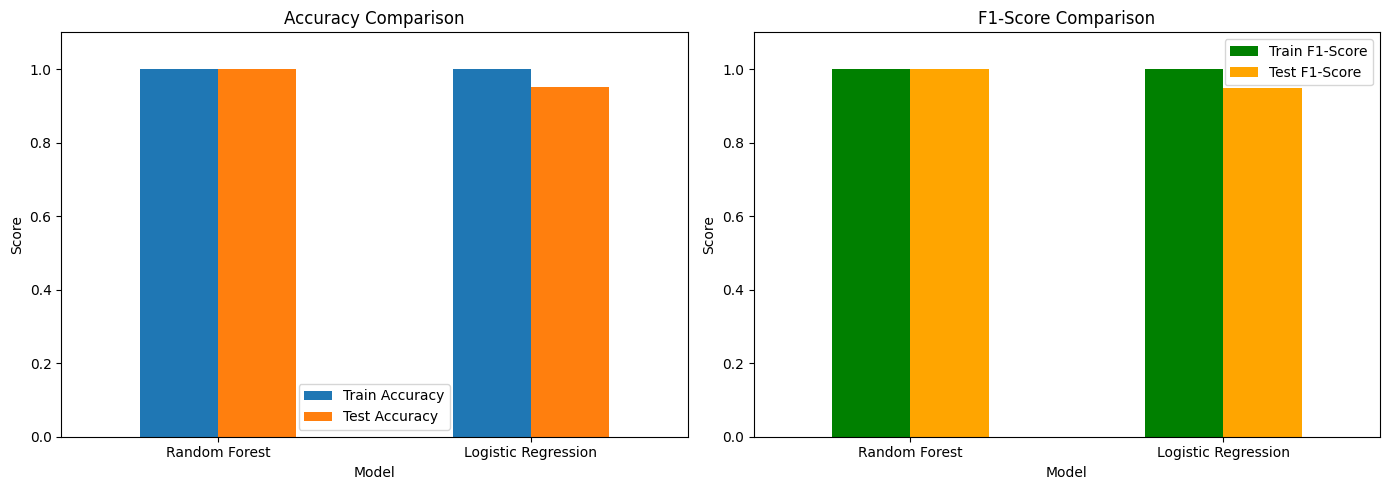

In [27]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Train Accuracy': [train_acc_rf, train_acc_lr],
    'Test Accuracy': [test_acc_rf, test_acc_lr],
    'Train F1-Score': [train_f1_rf, train_f1_lr],
    'Test F1-Score': [test_f1_rf, test_f1_lr]
})

print("Model Performance Comparison:")
print(comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comparison.plot(x='Model', y=['Train Accuracy', 'Test Accuracy'], 
               kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylabel('Score')
axes[0].set_ylim([0, 1.1])

comparison.plot(x='Model', y=['Train F1-Score', 'Test F1-Score'],
               kind='bar', ax=axes[1], rot=0, color=['green', 'orange'])
axes[1].set_title('F1-Score Comparison')
axes[1].set_ylabel('Score')
axes[1].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

## Step 13: Save Models

In [28]:
# Save all models and preprocessing objects
rf_path = os.path.join(MODEL_DIR, 'face_recognition_rf.pkl')
lr_path = os.path.join(MODEL_DIR, 'face_recognition_lr.pkl')
scaler_path = os.path.join(MODEL_DIR, 'scaler.pkl')
encoder_path = os.path.join(MODEL_DIR, 'label_encoder.pkl')

joblib.dump(rf_model, rf_path)
joblib.dump(lr_model, lr_path)
joblib.dump(scaler, scaler_path)
joblib.dump(label_encoder, encoder_path)

print("Models saved:")
print(f"  Random Forest: {rf_path}")
print(f"  Logistic Regression: {lr_path}")
print(f"  Scaler: {scaler_path}")
print(f"  Label Encoder: {encoder_path}")

Models saved:
  Random Forest: models\face_recognition_rf.pkl
  Logistic Regression: models\face_recognition_lr.pkl
  Scaler: models\scaler.pkl
  Label Encoder: models\label_encoder.pkl


## Step 14: Test Authentication

Test the model with sample images from the test set.

In [29]:
def test_authentication(image, model, scaler, label_encoder, threshold=0.5):
    """
    Test authentication with an image.
    """
    # Extract features
    features = extract_features(image)
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Predict
    prediction = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]
    confidence = probabilities.max()
    
    if confidence >= threshold:
        member_name = label_encoder.inverse_transform([prediction])[0]
        return True, member_name, confidence
    else:
        return False, None, confidence

# Test with a few random images from test set
test_indices = np.random.choice(len(X_test), min(3, len(X_test)), replace=False)

for i, idx in enumerate(test_indices):
    test_img = df_augmented.iloc[idx]['image']
    true_member = df_augmented.iloc[idx]['member']
    
    authenticated, predicted_member, confidence = test_authentication(
        test_img, rf_model, scaler, label_encoder
    )
    
    print(f"\nTest {i+1}:")
    print(f"  True member: {true_member}")
    if authenticated:
        print(f"  Predicted: {predicted_member}")
        print(f"  Confidence: {confidence:.2%}")
        print(f"  Status: Authenticated")
    else:
        print(f"  Status: Not authenticated (low confidence: {confidence:.2%})")


Test 1:
  True member: Member1
  Predicted: Member1
  Confidence: 98.00%
  Status: Authenticated

Test 2:
  True member: Member1
  Predicted: Member1
  Confidence: 88.00%
  Status: Authenticated

Test 2:
  True member: Member1
  Predicted: Member1
  Confidence: 88.00%
  Status: Authenticated

Test 3:
  True member: Member1
  Predicted: Member1
  Confidence: 98.00%
  Status: Authenticated

Test 3:
  True member: Member1
  Predicted: Member1
  Confidence: 98.00%
  Status: Authenticated


## Step 15: Visual Authentication Test

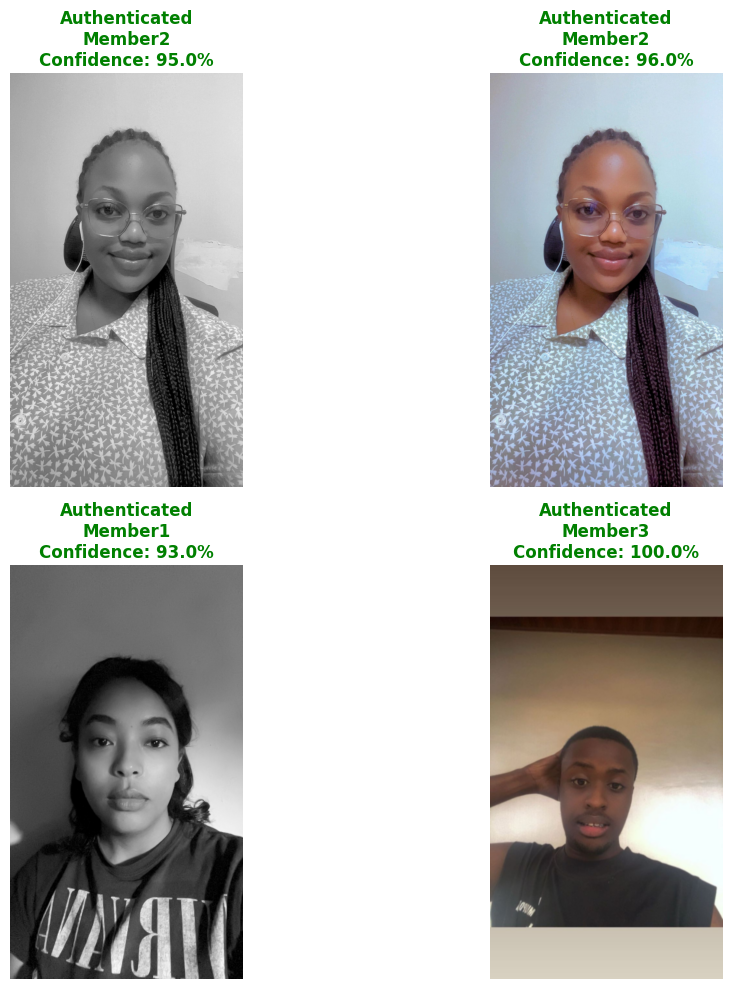

In [30]:
# Visual test with images
test_indices = np.random.choice(len(df_augmented), min(4, len(df_augmented)), replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, idx in enumerate(test_indices):
    test_img = df_augmented.iloc[idx]['image']
    true_member = df_augmented.iloc[idx]['member']
    
    authenticated, predicted_member, confidence = test_authentication(
        test_img, rf_model, scaler, label_encoder
    )
    
    axes[i].imshow(test_img)
    
    if authenticated:
        title = f"Authenticated\n{predicted_member}\nConfidence: {confidence:.1%}"
        color = 'green' if predicted_member == true_member else 'orange'
    else:
        title = f"Not Authenticated\nConfidence: {confidence:.1%}"
        color = 'red'
    
    axes[i].set_title(title, color=color, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Summary

This notebook completed the following:

1. Loaded team member images
2. Applied 8 augmentation techniques per image
3. Extracted 217 features per image
4. Saved features to image_features.csv
5. Trained Random Forest and Logistic Regression models
6. Evaluated models with accuracy, F1-score, and confusion matrices
7. Saved trained models for deployment
8. Tested authentication functionality

The facial recognition system is ready for integration with voice verification and product recommendation components.